## Classifying ordinary city sounds
After downloading the dataset, we see that it consists of two parts:
1. Audio files in the ‘audio’ folder: It has 10 sub-folders named ‘fold1’ through ‘fold10’. Each sub-folder contains a number of ‘.wav’ audio samples eg. ‘fold1/103074–7–1–0.wav’
2. Metadata in the ‘metadata’ folder: It has a file ‘UrbanSound8K.csv’ that contains information about each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on. The class label is a numeric Class ID from 0–9 for each of the 10 classes. eg. the number 0 means air conditioner, 1 is a car horn, and so on.

### Prepare training data
As for most deep learning problems, we will follow these steps:

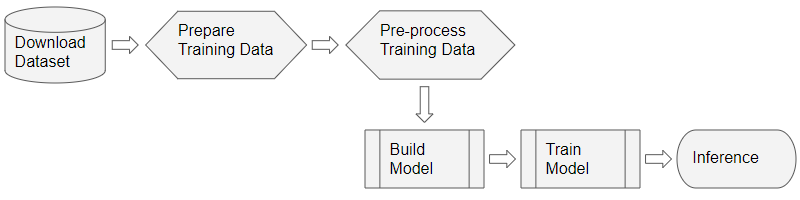

The training data for this problem will be fairly simple:

- The features (X) are the audio file paths
- The target labels (y) are the class names

### Scan the audio file directory when metadata isn’t available
Having the metadata file made things easy for us. How would we prepare our data for datasets that do not contain a metadata file?

Many datasets consist of only audio files arranged in a folder structure from which class labels can be derived.

### Audio Pre-processing: Define Transforms
This training data with audio file paths cannot be input directly into the model. We have to load the audio data from the file and process it so that it is in a format that the model expects.

This audio pre-processing will all be done dynamically at runtime when we will read and load the audio files. This approach is similar to what we would do with image files as well. Since audio data, like image data, can be fairly large and memory-intensive, we don’t want to read the entire dataset into memory all at once, ahead of time. So we keep only the audio file names (or image file names) in our training data.
Then, at runtime, as we train the model one batch at a time, we will load the audio data for that batch and process it by applying a series of transforms to the audio. That way we keep audio data for only one batch in memory at a time.
With image data, we might have a pipeline of transforms where we first read the image file as pixels and load it. Then we might apply some image processing steps to reshape and resize the data, crop them to a fixed size and convert them into grayscale from RGB. We might also apply some image augmentation steps like rotation, flips, and so on.
The processing for audio data is very similar. Right now we’re only defining the functions, they will be run a little later when we feed data to the model during training.

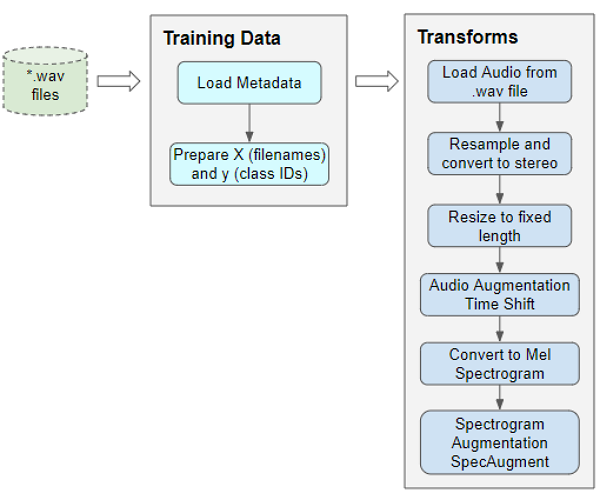

1. Read audio from a file
The first thing we need is to read and load the audio file in “.wav” format. Since we are using Pytorch for this example, the implementation below uses torchaudio for the audio processing, but librosa will work just as well.

2. Convert to two channels
Some of the sound files are mono (ie. 1 audio channel) while most of them are stereo (ie. 2 audio channels). Since our model expects all items to have the same dimensions, we will convert the mono files to stereo, by duplicating the first channel to the second.

3. Standardize sampling rate
Some of the sound files are sampled at a sample rate of 48000Hz, while most are sampled at a rate of 44100Hz. This means that 1 second of audio will have an array size of 48000 for some sound files, while it will have a smaller array size of 44100 for the others. Once again, we must standardize and convert all audio to the same sampling rate so that all arrays have the same dimensions.

4. Resize to the same length
We then resize all the audio samples to have the same length by either extending its duration by padding it with silence, or by truncating it. We add that method to our AudioUtil class.

5. Data Augmentation: Time Shift
Next, we can do data augmentation on the raw audio signal by applying a Time Shift to shift the audio to the left or the right by a random amount. I go into a lot more detail about this and other data augmentation techniques in this article.

6. Mel Spectrogram
We then convert the augmented audio to a Mel Spectrogram. They capture the essential features of the audio and are often the most suitable way to input audio data into deep learning models. To get more background about this, you might want to read my articles (here and here) which explain in simple words what a Mel Spectrogram is, why they are crucial for audio deep learning, as well as how they are generated and how to tune them for getting the best performance from your models.

7. Data Augmentation: Time and Frequency Masking
Now we can do another round of augmentation, this time on the Mel Spectrogram rather than on the raw audio. We will use a technique called SpecAugment that uses these two methods:

- Frequency mask — randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.
- Time mask — similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars.

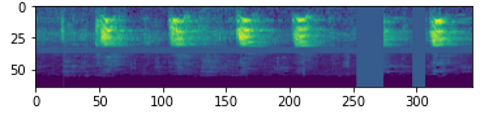

8. Define Custom Data Loader
Now that we have defined all the pre-processing transform functions we will define a custom Pytorch Dataset object.

To feed your data to a model with Pytorch, we need two objects:

1. A custom Dataset object that uses all the audio transforms to pre-process an audio file and prepares one data item at a time.
2. A built-in DataLoader object that uses the Dataset object to fetch individual data items and packages them into a batch of data.

code link : https://gist.github.com/ketanhdoshi/fa8ff15ffd3fbc98a1657eec860d010a#file-sound_classification_dataset-py

9. Prepare Batches of Data with the Data Loader
All of the functions we need to input our data to the model have now been defined.

We use our custom Dataset to load the Features and Labels from our Pandas dataframe and split that data randomly in an 80:20 ratio into training and validation sets. We then use them to create our training and validation Data Loaders.
When we start training, the Data Loader will randomly fetch one batch of input Features containing the list of audio file names and run the pre-processing audio transforms on each audio file. It will also fetch a batch of the corresponding target Labels containing the class IDs. Thus it will output one batch of training data at a time, which can directly be fed as input to our deep learning model.

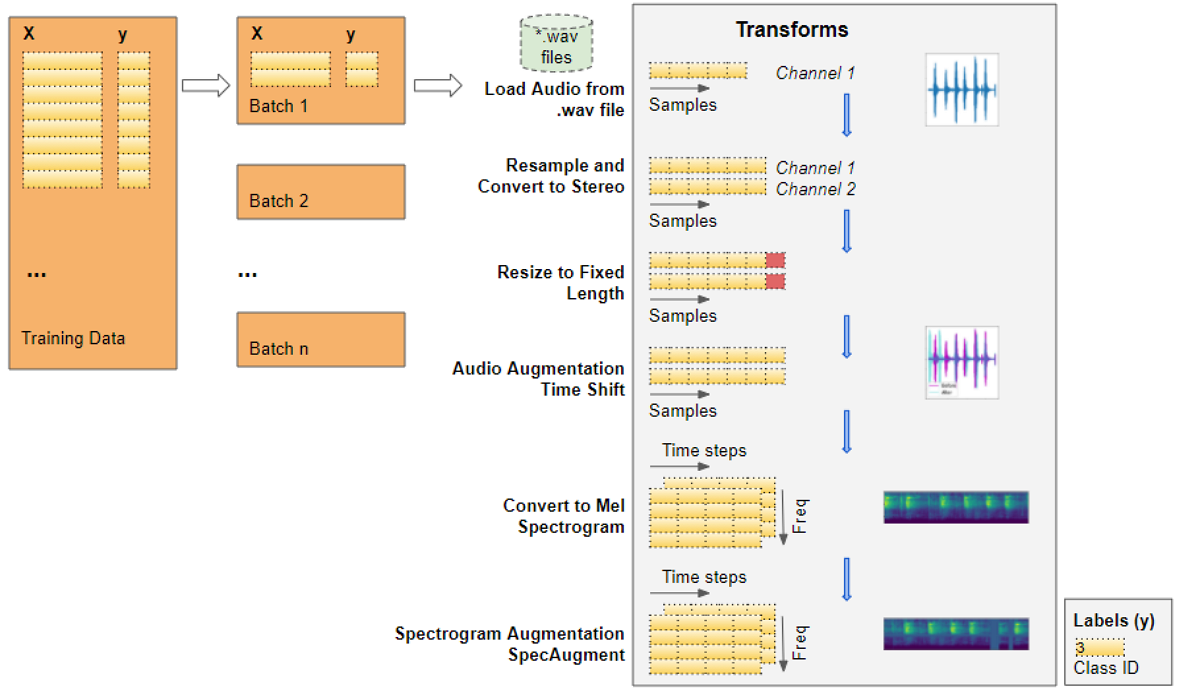

### Let’s walk through the steps as our data gets transformed, starting with an audio file:
1. The audio from the file gets loaded into a Numpy array of shape (num_channels, num_samples). Most of the audio is sampled at 44.1kHz and is about 4 seconds in duration, resulting in 44,100 * 4 = 176,400 samples. If the audio has 1 channel, the shape of the array will be (1, 176,400). Similarly, audio of 4 seconds duration with 2 channels and sampled at 48kHz will have 192,000 samples and a shape of (2, 192,000).
2. Since the channels and sampling rates of each audio are different, the next two transforms resample the audio to a standard 44.1kHz and to a standard 2 channels.
3. Since some audio clips might be more or less than 4 seconds, we also standardize the audio duration to a fixed length of 4 seconds. Now arrays for all items have the same shape of (2, 176,400)
4. The Time Shift data augmentation now randomly shifts each audio sample forward or backward. The shapes are unchanged.
5. The augmented audio is now converted into a Mel Spectrogram, resulting in a shape of (num_channels, Mel freq_bands, time_steps) = (2, 64, 344)
6. The SpecAugment data augmentation now randomly applies Time and Frequency Masks to the Mel Spectrograms. The shapes are unchanged.
Thus, each batch will have two tensors, one for the X feature data containing the Mel Spectrograms and the other for the y target labels containing numeric Class IDs. The batches are picked randomly from the training data for each training epoch.

Each batch has a shape of (batch_sz, num_channels, Mel freq_bands, time_steps)


### Create Model

The data processing steps that we just did are the most unique aspects of our audio classification problem. From here on, the model and training procedure are quite similar to what is commonly used in a standard image classification problem and are not specific to audio deep learning.

Since our data now consists of Spectrogram images, we build a CNN classification architecture to process them. It has four convolutional blocks which generate the feature maps. That data is then reshaped into the format we need so it can be input into the linear classifier layer, which finally outputs the predictions for the 10 classes.

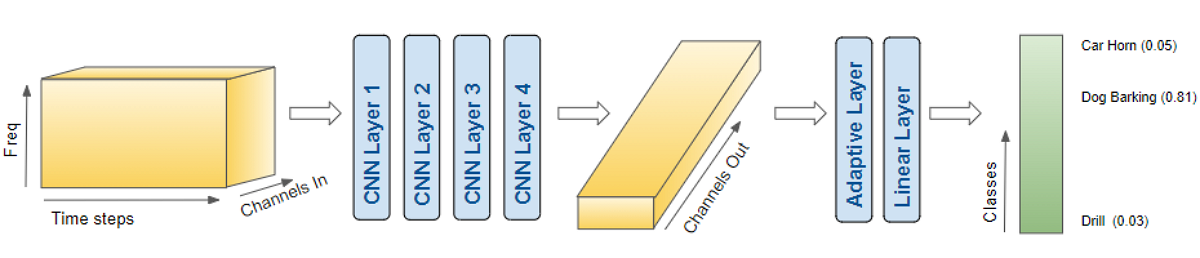

A few more details about how the model processes a batch of data:
- A batch of images is input to the model with shape (batch_sz, num_channels, Mel freq_bands, time_steps) ie. (16, 2, 64, 344).
- Each CNN layer applies its filters to step up the image depth ie. number of channels. The image width and height are reduced as the kernels and strides are applied. Finally, after passing through the four CNN layers, we get the output feature maps ie. (16, 64, 4, 22).
- This gets pooled and flattened to a shape of (16, 64) and then input to the Linear layer.
- The Linear layer outputs one prediction score per class ie. (16, 10)

code link : https://gist.github.com/ketanhdoshi/9bce0a7099e18a88246ae15c4b857eb2#file-sound_classification_model-py

### Training
We are now ready to create the training loop to train the model.

We define the functions for the optimizer, loss, and scheduler to dynamically vary our learning rate as training progresses, which usually allows training to converge in fewer epochs.

We train the model for several epochs, processing a batch of data in each iteration. We keep track of a simple accuracy metric which measures the percentage of correct predictions.

code link: https://gist.github.com/ketanhdoshi/f0922e2d3c8eb3b9d2531f8fc9d114fa#file-sound_classification_training-py

### Inference

Ordinarily, as part of the training loop, we would also evaluate our metrics on the validation data. We would then do inference on unseen data, perhaps by keeping aside a test dataset from the original data. However, for the purposes of this demo, we will use the validation data for this purpose.

We run an inference loop taking care to disable the gradient updates. The forward pass is executed with the model to get predictions, but we do not need to backpropagate or run the optimizer.





## Speech-to-Text algorithm and architecture, including Mel Spectrograms, MFCCs, CTC Loss and Decoder, in Plain English.

Over the last few years, Voice Assistants have become ubiquitous with the popularity of Google Home, Amazon Echo, Siri, Cortana, and others. These are the most well-known examples of Automatic Speech Recognition (ASR). This class of applications starts with a clip of spoken audio in some language and extracts the words that were spoken, as text. For this reason, they are also known as Speech-to-Text algorithms.
Of course, applications like Siri and the others mentioned above, go further. Not only do they extract the text but they also interpret and understand the semantic meaning of what was spoken, so that they can respond with answers, or take actions based on the user’s commands.


### Speech-to-Text
Problems like audio classification start with a sound clip and predict which class that sound belongs to, from a given set of classes. For Speech-to-Text problems, your training data consists of:

Input features (X): audio clips of spoken words
Target labels (y): a text transcript of what was spoken

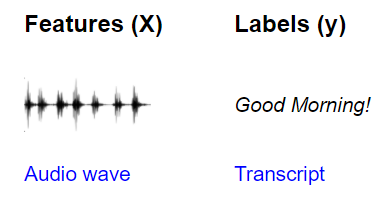

### 1. Data pre-processing

In the sound classification article, I explain, step-by-step, the transforms that are used to process audio data for deep learning models. With human speech as well we follow a similar approach. There are several Python libraries that provide the functionality to do this, with librosa being one of the most popular.

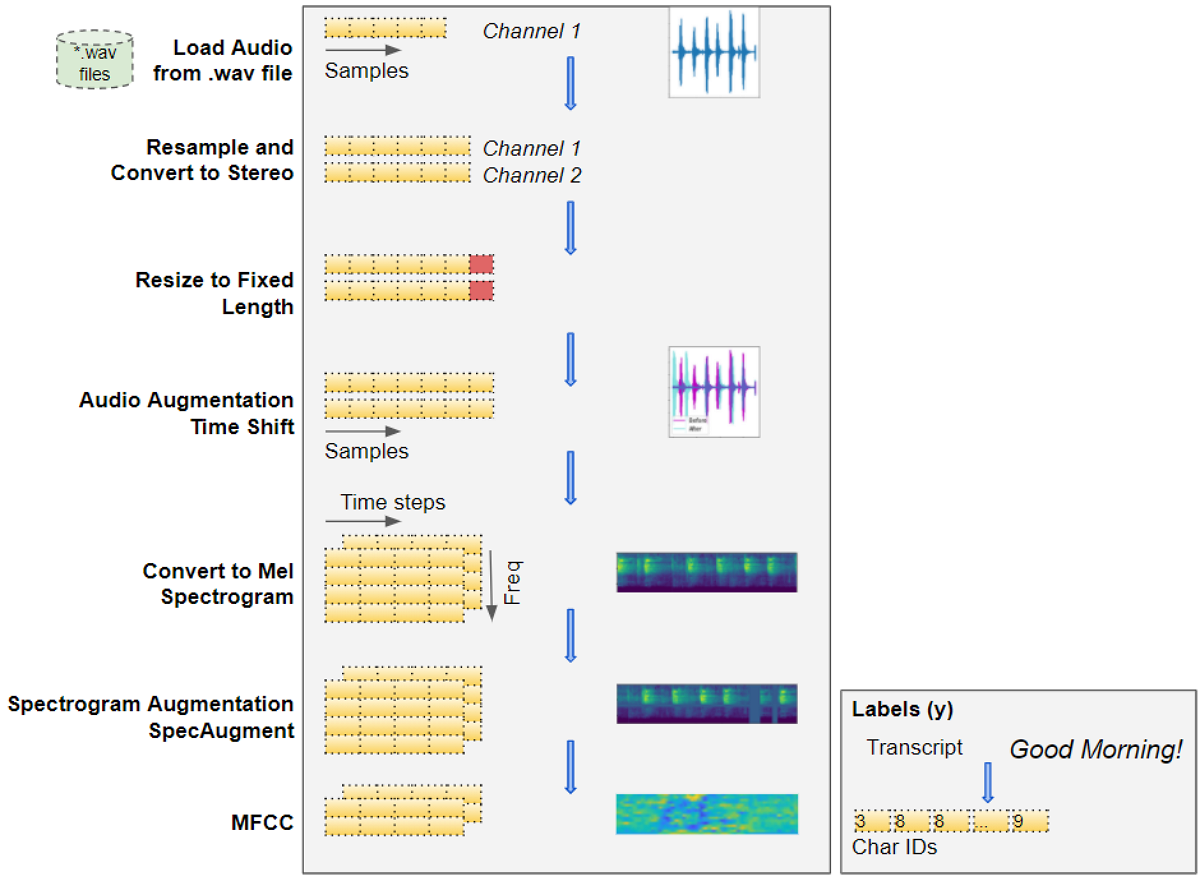

### 2. Load Audio Files
- Start with input data that consists of audio files of the spoken speech in an audio format such as “.wav” or “.mp3”.
- Read the audio data from the file and load it into a 2D Numpy array. This array consists of a sequence of numbers, each representing a measurement of the intensity or amplitude of the sound at a particular moment in time. The number of such measurements is determined by the sampling rate. For instance, if the sampling rate was 44.1kHz, the Numpy array will have a single row of 44,100 numbers for 1 second of audio.
- Audio can have one or two channels, known as mono or stereo, in common parlance. With two-channel audio, we would have another similar sequence of amplitude numbers for the second channel. In other words, our Numpy array will be 3D, with a depth of 2.

### 3. Convert to uniform dimensions: sample rate, channels, and duration
- We might have a lot of variation in our audio data items. Clips might be sampled at different rates, or have a different number of channels. The clips will most likely have different durations. As explained above this means that the dimensions of each audio item will be different.
- Since our deep learning models expect all our input items to have a similar size, we now perform some data cleaning steps to standardize the dimensions of our audio data. We resample the audio so that every item has the same sampling rate. We convert all items to the same number of channels. All items also have to be converted to the same audio duration. This involves padding the shorter sequences or truncating the longer sequences.
- `If the quality of the audio was poor, we might enhance it by applying a noise-removal algorithm to eliminate background noise so that we can focus on the spoken audio`.

### 4. Data Augmentation of raw audio
We could apply some data augmentation techniques to add more variety to our input data and help the model learn to generalize to a wider range of inputs. We could Time Shift our audio left or right randomly by a small percentage, or change the Pitch or the Speed of the audio by a small amount.

### 5. Mel Spectrograms
This raw audio is now converted to Mel Spectrograms. A Spectrogram captures the nature of the audio as an image by decomposing it into the set of frequencies that are included in it.

### 6. MFCC

For human speech, in particular, it sometimes helps to take one additional step and convert the Mel Spectrogram into MFCC (Mel Frequency Cepstral Coefficients). MFCCs produce a compressed representation of the Mel Spectrogram by extracting only the most essential frequency coefficients, which correspond to the frequency ranges at which humans speak.

### 7. Data Augmentation of Spectrograms
We can now apply another data augmentation step on the Mel Spectrogram images, using a technique known as SpecAugment. This involves Frequency and Time Masking that randomly masks out either vertical (ie. Time Mask) or horizontal (ie. Frequency Mask) bands of information from the Spectrogram. NB: I’m not sure whether this can also be applied to MFCCs and whether that produces good results.

### 8. Architecture
There are many variations of deep learning architecture for ASR. Two commonly used approaches are:

    1. A CNN plus RNN-based architecture that uses the CTC Loss algorithm to demarcate each character of the words in the speech. eg. Baidu’s Deep Speech model.
        A regular convolutional network consisting of a few Residual CNN layers that process the input spectrogram images and output feature maps of those images.

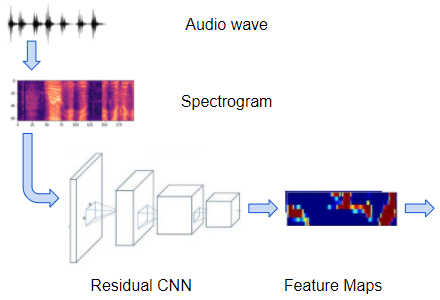

    2. An RNN-based sequence-to-sequence network that treats each ‘slice’ of the spectrogram as one element in a sequence eg. Google’s Listen Attend Spell (LAS) model.
        A regular recurrent network consisting of a few Bidirectional LSTM layers that process the feature maps as a series of distinct timesteps or ‘frames’ that correspond to our desired sequence of output characters. In other words, it takes the feature maps which are a continuous representation of the audio, and converts them into a discrete representation.

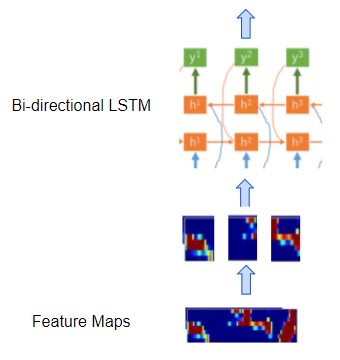

        A linear layer with softmax that uses the LSTM outputs to produce character probabilities for each timestep of the output.

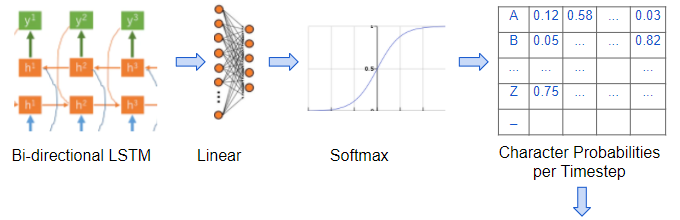

        Linear layer generates character probabilities for each timestep (Image by Author)

We also have linear layers that sit between the convolution and recurrent networks and help to reshape the outputs of one network to the inputs of the other.
So our model takes the Spectrogram images and outputs character probabilities for each timestep or ‘frame’ in that Spectrogram.

### 9. Align the sequences

If you think about this a little bit, you’ll realize that there is still a major missing piece in our puzzle. Our eventual goal is to map those timesteps or ‘frames’ to individual characters in our target transcript.

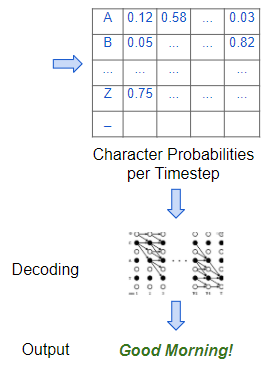

The model decodes the character probabilities to produce the final output (Image by Author)

But for a particular spectrogram, how do we know how many frames there should be? How do we know exactly where the boundaries of each frame are? **How do we align the audio with each character in the text transcript?**

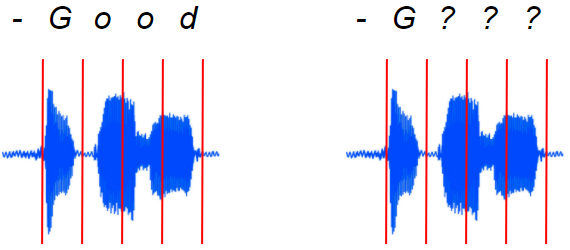

On the left is the alignment we need. But how do we get it?? (Image by Author)

The audio and the spectrogram images are not pre-segmented to give us this information.

In the spoken audio, and therefore in the spectrogram, the sound of each character could be of different durations.
There could be gaps and pauses between these characters.
Several characters could be merged together.
Some characters could be repeated. eg. in the word ‘apple’, how do we know whether that “p” sound in the audio actually corresponds to one or two “p”s in the transcript?

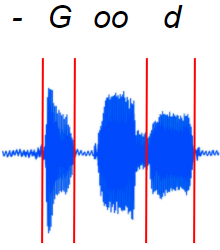

This is actually a very challenging problem, and what makes ASR so tough to get right. It is the distinguishing characteristic that differentiates ASR from other audio applications like classification and so on.

**The way we tackle this is by using an ingenious algorithm with a fancy-sounding name — it is called Connectionist Temporal Classification, or CTC** for short. Since I am not ‘fancy people’ and find it difficult to remember that long name, I will just use the name CTC to refer to it 

### 10. CTC Algorithm — Training and Inference

CTC is used to align the input and output sequences when the input is continuous and the output is discrete, and there are no clear element boundaries that can be used to map the input to the elements of the output sequence.

What makes this so special is that it performs this alignment automatically, without requiring you to manually provide that alignment as part of the labeled training data. That would have made it extremely expensive to create the training datasets.

As we discussed above, the feature maps that are output by the convolutional network in our model are sliced into separate frames and input to the recurrent network. Each frame corresponds to some timestep of the original audio wave. However, the number of frames and the duration of each frame are chosen by you as hyperparameters when you design the model. For each frame, the recurrent network followed by the linear classifier then predicts probabilities for each character from the vocabulary.

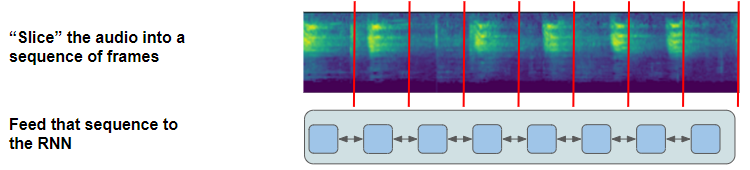

The continuous audio is sliced into discrete frames and input to the RNN (Image by Author)
The job of the CTC algorithm is to take these character probabilities and derive the correct sequence of characters.

To help it handle the challenges of alignment and repeated characters that we just discussed, it introduces the concept of a ‘blank’ pseudo-character (denoted by “-”) into the vocabulary. Therefore the character probabilities output by the network also include the probability of the blank character for each frame.

Note that a blank is not the same as a ‘space’. A space is a real character while a blank means the absence of any character, somewhat like a ‘null’ in most programming languages. It is used only to demarcate the boundary between two characters.

CTC works in two modes:

- CTC Loss (during Training): It has a ground truth target transcript and tries to train the network to maximize the probability of outputting that correct transcript.
    The Loss is computed as the probability of the network predicting the correct sequence. To do this, the algorithm lists out all possible sequences the network can predict, and from that it selects the subset that match the target transcript.

    To identify that subset from the full set of possible sequences, the algorithm narrows down the possibilities as follows:
    - Keep only the probabilities for characters that occur in the target transcript and discard the rest. eg. It keeps probabilities only for “G”, “o”, “d”, and “-”.
    - Using the filtered subset of characters, for each frame, select only those characters which occur in the same order as the target transcript. eg. Although “G” and “o” are both valid characters, an order of “Go” is a valid sequence whereas “oG” is an invalid sequence.

    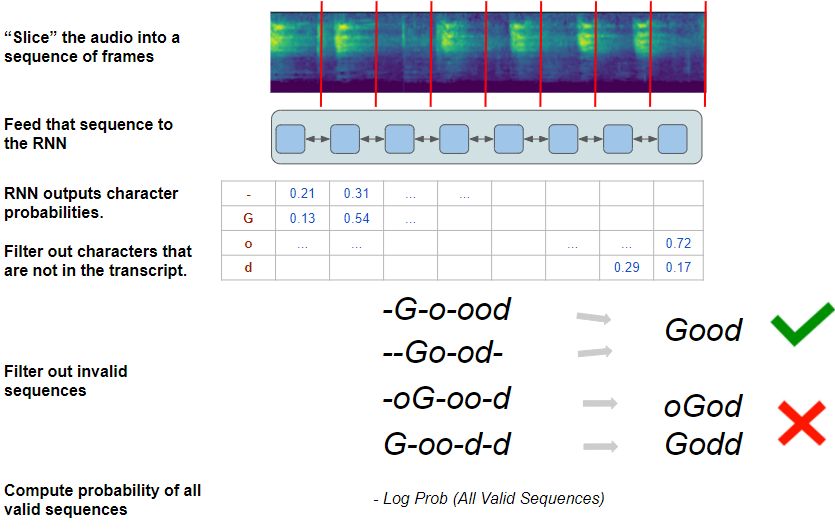


- CTC Decoding (during Inference): Here we don’t have a target transcript to refer to, and have to predict the most likely sequence of characters.
    Use the character probabilities to pick the most likely character for each frame, including blanks. eg. “-G-o-ood”

    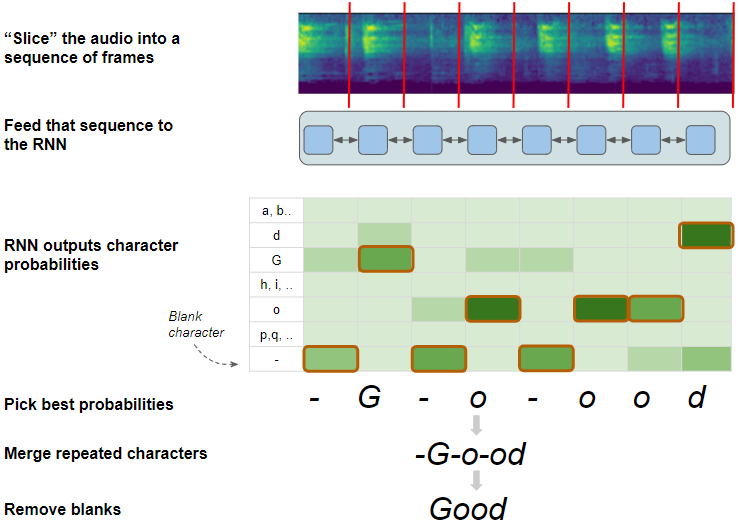

    CTC Decode algorithm (Image by Author)

    Merge any characters that are repeated, and not separated by a blank. For instance, we can merge the “oo” into a single “o”, but we cannot merge the “o-oo”. This is how the CTC is able to distinguish that there are two separate “o”s and produce words spelled with repeated characters. eg. “-G-o-od”
    Finally, since the blanks have served their purpose, it removes all blank characters. eg. “Good”.

With these constraints in place, the algorithm now has a set of valid character sequences, all of which will produce the correct target transcript. eg. Using the same steps that were used during Inference, “-G-o-ood” and “_ — Go-od-_” will both result in a final output of “Good”.

It then uses the individual character probabilities for each frame, to compute the overall probability of generating all of those valid sequences. The goal of the network is to learn how to maximize that probability and therefore reduce the probability of generating any invalid sequence.

Strictly speaking, since a neural network minimizes loss, the CTC Loss is computed as the negative log probability of all valid sequences. As the network minimizes that loss via back-propagation during training, it adjusts all of its weights to produce the correct sequence.

To actually do this, however, is much more complicated than what I’ve described here. The challenge is that there is a huge number of possible combinations of characters to produce a sequence. With our simple example alone, we can have 4 characters per frame. With 8 frames that gives us 4 ** 8 combinations (= 65536). For any realistic transcript with more characters and more frames, this number increases exponentially. That makes it computationally impractical to simply exhaustively list out the valid combinations and compute their probability.

### 11. Metrics — Word Error Rate (WER)
After training our network, we must evaluate how well it performs. A commonly used metric for Speech-to-Text problems is the Word Error Rate (and Character Error Rate). It compares the predicted output and the target transcript, word by word (or character by character) to figure out the number of differences between them.

A difference could be a word that is present in the transcript but missing from the prediction (counted as a Deletion), a word that is not in the transcript but has been added into the prediction (an Insertion), or a word that is altered between the prediction and the transcript (a Substitution).

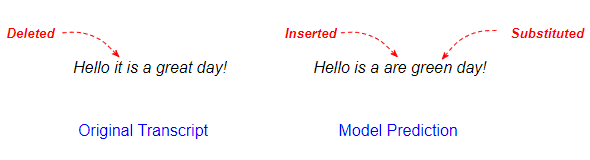

The metric formula is fairly straightforward. It is the percent of differences relative to the total number of words.

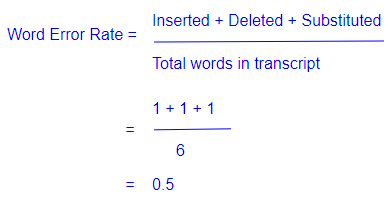

### 12. Beam Search
While describing the CTC Decoder during Inference, we implicitly assumed that it always picks a single character with the highest probability at each timestep. This is known as Greedy Search.

However, we know that we can get better results using an alternative method called Beam Search.

Although Beam Search is often used with NLP problems in general, it is not specific to ASR, so I’m mentioning it here just for completeness. If you’d like to know more, please take a look at my article that describes Beam Search in full detail.



